# Shuffle, Register and Average (SRA) volume denoising

In [1]:
#use_opticalflow3D = False

In [2]:
#vol_name = "small_vol"

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Colab")
    !pip install cupy-cuda12x
    !pip install opticalflow3D
    !apt install libcudart11.0
    !apt install libcublas11
    !apt install libcufft10
    !apt install libcusparse11
    !apt install libnvrtc11.2
    from google.colab import drive
    drive.mount('/content/drive')
    !cp drive/Shareddrives/TomogramDenoising/tomograms/{vol_name}.tif .
else:
    print("Running in locahost")
    !cp ~/Downloads/{vol_name}.tif .

In [3]:
vol_filename = "small_vol.mrc"

In [4]:
from collections import namedtuple
Args = namedtuple("args", ["input", "output"])
fn, fe = vol_filename.split(".")
args = Args(vol_filename , fn + "_denoised." + fe)
print(args)

args(input='small_vol.mrc', output='small_vol_denoised.mrc')


In [5]:
#%pip install gdown

In [6]:
%%bash -s "$args.input"
set -x
OUTPUT_FILENAME=$1
#rm -f $OUTPUT_FILENAME
if test ! -f $OUTPUT_FILENAME ; then
    FILEID="1YDyHWyB1d6yq2LYif2zQcQgr7vhlspYo" # https://drive.google.com/file/d/1YDyHWyB1d6yq2LYif2zQcQgr7vhlspYo/view?usp=sharing
    #FILEID="1iui018SGKa5nb0ybeoUAB7uCUhl9EJ5o" #https://drive.google.com/file/d/1iui018SGKa5nb0ybeoUAB7uCUhl9EJ5o/view?usp=sharing
    #wget --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O $OUTPUT_FILENAME #2> /dev/null
    #wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=FILEID" -O FILENAME && rm -rf /tmp/cookies.txt
    gdown https://drive.google.com/uc?id=$FILEID # pip install gdown
fi
ls -l $OUTPUT_FILENAME
set +x

+ OUTPUT_FILENAME=small_vol.mrc
+ test '!' -f small_vol.mrc
+ ls -l small_vol.mrc


-rw-r--r-- 1 vruiz vruiz 8389632 Feb 14  2024 small_vol.mrc


+ set +x


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [8]:
#!pip install --force-reinstall "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"

In [9]:
import motion_estimation # pip install --force-reinstall "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"

In [10]:
import information_theory  # pip install --force-reinstall "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"

In [11]:
#import opticalflow3D
#import warnings
#from numba.core.errors import NumbaPerformanceWarning
import numpy as np
#warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
#else:
#    import motion_estimation._3D.farneback as farneback3D

In [12]:
import mrcfile
from collections import namedtuple

In [13]:
stack_MRC = mrcfile.open(args.input)
noisy = stack_MRC.data
print(noisy.shape)

(32, 256, 256)


In [14]:
import volume.SRA

In [15]:
noisy = (255*(noisy - np.min(noisy))/(np.max(noisy) - np.min(noisy))).astype(np.uint8)

In [16]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.setLevel(logging.WARNING)

In [17]:
import motion_estimation._3D.farneback as farneback3D
OF_estimator = farneback3D.OF_Estimation(logger)

In [18]:
import motion_estimation._3D.project as project
projector = project.Project(logger)

In [19]:
import volume.SRA as SRA
denoiser = SRA.SRA(OF_estimator, projector, logger, None, False)

 iter             min         avg_abs             max        min_flow    avg_abs_flow        max_flow            time
    1           -3.09            0.83            2.57           -2.58            0.12            2.52           40.27
    2           -3.11            0.79            3.15          -14.83            0.48           10.58           39.83
    3           -2.63            0.83            3.00          -28.64            0.92           12.94           39.93
    4           -2.60            0.78            3.48          -39.02            1.86           26.15           39.93
    5           -2.93            0.80            3.34          -58.52            2.90           35.78           39.83
    6           -2.67            0.82            2.95          -57.70            3.20           37.25           39.92
    7           -2.80            0.80            3.28          -39.05            3.05           37.67           40.47
    8           -2.37            0.80            2.70   

In [20]:
denoised = denoiser.filter(noisy_volume=noisy)

pyr1.shape: (8, 64, 64)
flow.shape: (4, 32, 32, 3)
expanded_Z_flow.shape: (8, 64, 64)
flow[..., 0].shape= (8, 64, 64)
pyr1.shape: (16, 128, 128)
flow.shape: (8, 64, 64, 3)
expanded_Z_flow.shape: (16, 128, 128)
flow[..., 0].shape= (16, 128, 128)
pyr1.shape: (32, 256, 256)
flow.shape: (16, 128, 128, 3)
expanded_Z_flow.shape: (32, 256, 256)
flow[..., 0].shape= (32, 256, 256)
pyr1.shape: (8, 64, 64)
flow.shape: (4, 32, 32, 3)
expanded_Z_flow.shape: (8, 64, 64)
flow[..., 0].shape= (8, 64, 64)
pyr1.shape: (16, 128, 128)
flow.shape: (8, 64, 64, 3)
expanded_Z_flow.shape: (16, 128, 128)
flow[..., 0].shape= (16, 128, 128)
pyr1.shape: (32, 256, 256)
flow.shape: (16, 128, 128, 3)
expanded_Z_flow.shape: (32, 256, 256)
flow[..., 0].shape= (32, 256, 256)
pyr1.shape: (8, 64, 64)
flow.shape: (4, 32, 32, 3)
expanded_Z_flow.shape: (8, 64, 64)
flow[..., 0].shape= (8, 64, 64)
pyr1.shape: (16, 128, 128)
flow.shape: (8, 64, 64, 3)
expanded_Z_flow.shape: (16, 128, 128)
flow[..., 0].shape= (16, 128, 128)
pyr1.

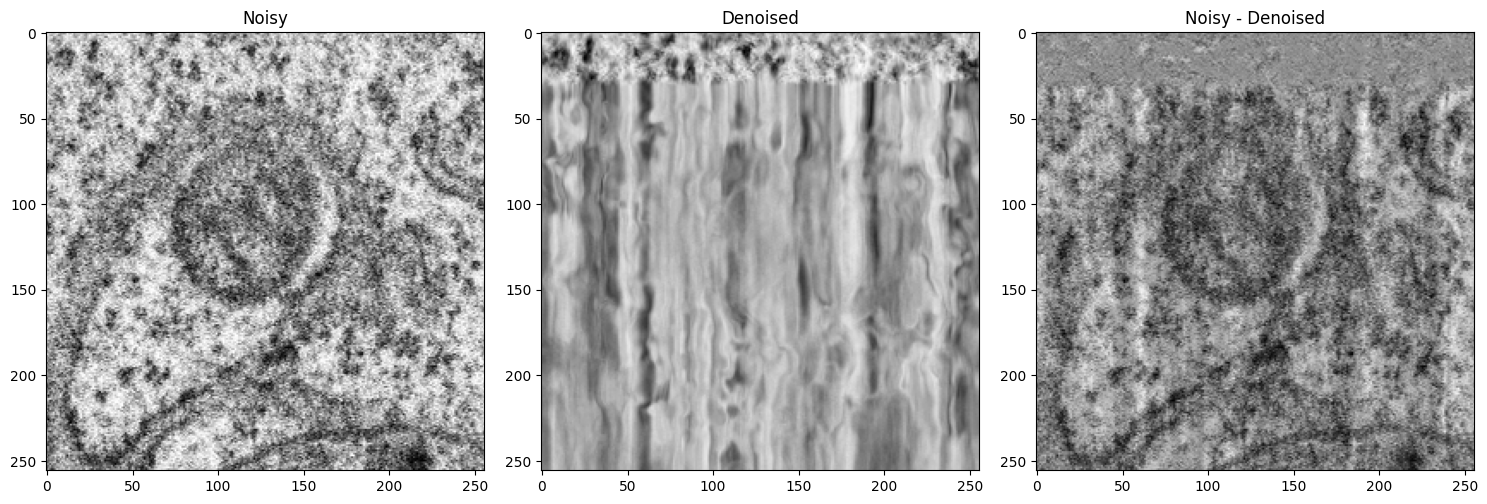

In [26]:
import information_theory
slice_index = noisy.shape[0]//2
fig, axs = plt.subplots(1, 3, figsize=(15, 45))
axs[0].imshow(noisy[16], cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised[slice_index], cmap="gray")
#axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy[slice_index], denoised[slice_index])})")
axs[1].set_title(f"Denoised")
axs[2].imshow(noisy[slice_index] - denoised[slice_index], cmap="gray")
axs[2].set_title(f"Noisy - Denoised")
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 32))
slice_idx = noisy.shape[1]//2
axs[0].imshow(noisy[:, slice_idx], cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised[:, slice_idx], cmap="gray")
axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy[:, slice_idx], denoised[:, slice_idx])})")
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 32))
slice_idx = noisy.shape[2]//2
axs[0].imshow(noisy[:, :, slice_idx], cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised[:, :, slice_idx], cmap="gray")
axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy[:, :, slice_idx], denoised[:, :, slice_idx])})")
fig.tight_layout()
plt.show()

In [ ]:
with mrcfile.new(f"{fn}_SRA_denoised.mrc", overwrite=True) as mrc:
    mrc.set_data(denoised.astype(np.float32))
    mrc.data